## Scala Version

In [8]:
!scala -version

Scala code runner version 2.12.10 -- Copyright 2002-2019, LAMP/EPFL and Lightbend, Inc.


## Creating Spark Session

In [9]:
from pyspark.sql import SparkSession
spark = SparkSession.builder \
  .appName('1.1. BigQuery Storage & Spark DataFrames - Python')\
  .config('spark.jars', 'gs://spark-lib/bigquery/spark-bigquery-latest_2.12.jar') \
  .getOrCreate()

## Enable repl.eagerEval

In [10]:
# This will output the results of DataFrames in each step without the new need to show df.show() and also improves the formatting of the output

spark.conf.set("spark.sql.repl.eagerEval.enabled",True)

## Reading BigQuery table into Spark DataFrame

In [11]:
# Filtered for english version of Wikipedia for both desktop and mobile versions

table = "bigquery-public-data.wikipedia.pageviews_2020"
df_wiki_pageviews = spark.read \
  .format("bigquery") \
  .option("table", table) \
  .option("filter", "datehour >= '2020-03-01' AND datehour < '2020-03-02'") \
  .load()

df_wiki_pageviews.printSchema()

root
 |-- datehour: timestamp (nullable = true)
 |-- wiki: string (nullable = true)
 |-- title: string (nullable = true)
 |-- views: long (nullable = true)



## Selecting the required columns and filtering for English version

In [12]:
df_wiki_en = df_wiki_pageviews \
  .select("title", "wiki", "views") \
  .where("views > 1000 AND wiki in ('en', 'en.m')") \
  .cache()

df_wiki_en

title,wiki,views
-,en,143159
-,en,14969
-,en,186802
-,en,131686
-,en,213787
-,en,211910
-,en,186675
-,en,21901
-,en,163710
-,en,23527


## Grouping by title and ordering by page views to see the top pages

In [13]:
import pyspark.sql.functions as F

df_wiki_en_totals = df_wiki_en \
.groupBy("title") \
.agg(F.sum('views').alias('total_views'))

df_wiki_en_totals.orderBy('total_views', ascending=False)

title,total_views
Main_Page,10939337
United_States_Senate,5619797
-,3852360
Special:Search,1538334
2019–20_coronavir...,407042
2020_Democratic_P...,260093
Coronavirus,254861
The_Invisible_Man...,233718
Super_Tuesday,201077
Colin_McRae,200219


## Writing Spark Dataframe to BigQuery table

In [14]:
# Update to your GCS bucket
gcs_bucket = 'andrewmarfo'

# Update to your BigQuery dataset name you created
bq_dataset = 'wikidataset2024'

# Enter BigQuery table name you want to create or overwite. 
# If the table does not exist it will be created when you run the write function
bq_table = 'wiki_total_pageviews'

df_wiki_en_totals.write \
  .format("bigquery") \
  .option("table","{}.{}".format(bq_dataset, bq_table)) \
  .option("temporaryGcsBucket", gcs_bucket) \
  .mode('overwrite') \
  .save()

## USING SPARK SQL

## Checking the Scala version

In [2]:
!scala -version

Scala code runner version 2.12.10 -- Copyright 2002-2019, LAMP/EPFL and Lightbend, Inc.


## Creating Spark Session

In [3]:
from pyspark.sql import SparkSession
spark = SparkSession.builder \
    .appName('1.2. BigQuery Storage & Spark SQL - Python')\
    .config('spark.jars', 'gs://spark-lib/bigquery/spark-bigquery-latest_2.12.jar') \
    .getOrCreate()

## Enable repl.eagerEval

In [4]:
# This will output the results of DataFrames in each step without the new need to show df.show() and also improves the formatting of the output

spark.conf.set("spark.sql.repl.eagerEval.enabled",True)

## Reading BigQuery table into Spark Dataframe

In [5]:
table = "bigquery-public-data.wikipedia.pageviews_2020"
df_wiki_pageviews = spark.read \
  .format("bigquery") \
  .option("table", table) \
  .option("filter", "datehour >= '2020-03-01' AND datehour < '2020-03-02'") \
  .load()

df_wiki_pageviews.printSchema()

root
 |-- datehour: timestamp (nullable = true)
 |-- wiki: string (nullable = true)
 |-- title: string (nullable = true)
 |-- views: long (nullable = true)



## Creating temp table

In [6]:
# Creating temp table to be used in Spark SQL queries
df_wiki_pageviews.createOrReplaceTempView("wiki_pageviews")

# Selecting required columns and appling a filter using WHERE
df_wiki_en = spark.sql("""
SELECT 
 title, wiki, views
FROM wiki_pageviews
WHERE views > 1000 AND wiki in ('en', 'en.m')
""").cache()

df_wiki_en

title,wiki,views
-,en,143159
-,en,14969
-,en,186802
-,en,131686
-,en,213787
-,en,211910
-,en,186675
-,en,21901
-,en,163710
-,en,23527


## Creating a wiki en pageviews table

In [7]:
df_wiki_en.createOrReplaceTempView("wiki_en")

## Grouping by title and finding the top pages by page views

In [8]:
df_wiki_en_totals = spark.sql("""
SELECT 
 title, 
 SUM(views) as total_views
FROM wiki_en
GROUP BY title
ORDER BY total_views DESC
""")

df_wiki_en_totals

title,total_views
Main_Page,10939337
United_States_Senate,5619797
-,3852360
Special:Search,1538334
2019–20_coronavir...,407042
2020_Democratic_P...,260093
Coronavirus,254861
The_Invisible_Man...,233718
Super_Tuesday,201077
Colin_McRae,200219


## Writing Spark Dataframe to BigQuery table

In [9]:
# Updating GCS bucket
gcs_bucket = 'andrewmarfo'

# Updating dataset
bq_dataset = 'wikidataset2024'

# Enter BigQuery table name you want to create or overwite. 
# If the table does not exist it will be created when you run the write function
bq_table = 'wiki_total_pageviews'

df_wiki_en_totals.write \
  .format("bigquery") \
  .option("table","{}.{}".format(bq_dataset, bq_table)) \
  .option("temporaryGcsBucket", gcs_bucket) \
  .mode('overwrite') \
  .save()

## Spark DataFrames & Pandas Plotting - Python

### Reading BigQuery table into Spark DataFrame. Filtering to include the datehour

In [11]:
table = "bigquery-public-data.wikipedia.pageviews_2020"

df_wiki_pageviews = spark.read \
  .format("bigquery") \
  .option("table", table) \
  .option("filter", "datehour >= '2020-03-01' AND datehour < '2020-03-02'") \
  .load()

df_wiki_pageviews.printSchema()

root
 |-- datehour: timestamp (nullable = true)
 |-- wiki: string (nullable = true)
 |-- title: string (nullable = true)
 |-- views: long (nullable = true)



## Selecting required columns and applying a filter using where() which is an alias for filter() then caching the table

In [12]:
df_wiki_en = df_wiki_pageviews \
  .select("datehour", "wiki", "views") \
  .where("views > 1000 AND wiki in ('en', 'en.m')") \
  .cache()

df_wiki_en

datehour,wiki,views
2020-03-01 16:00:00,en,143159
2020-03-01 02:00:00,en,14969
2020-03-01 13:00:00,en,186802
2020-03-01 10:00:00,en,131686
2020-03-01 21:00:00,en,213787
2020-03-01 07:00:00,en,211910
2020-03-01 18:00:00,en,186675
2020-03-01 04:00:00,en,21901
2020-03-01 15:00:00,en,163710
2020-03-01 01:00:00,en,23527


## Grouping by title and ordering by page views to see the top pages

In [13]:
import pyspark.sql.functions as F

df_datehour_totals = df_wiki_en \
.groupBy("datehour") \
.agg(F.sum('views').alias('total_views'))

df_datehour_totals.orderBy('total_views', ascending=False)

datehour,total_views
2020-03-01 21:00:00,1642981
2020-03-01 06:00:00,1591160
2020-03-01 22:00:00,1541455
2020-03-01 17:00:00,1535983
2020-03-01 18:00:00,1495387
2020-03-01 16:00:00,1487786
2020-03-01 05:00:00,1469068
2020-03-01 07:00:00,1458756
2020-03-01 20:00:00,1457051
2020-03-01 15:00:00,1446984


## Converting Spark DataFrame to Pandas DataFrame

In [14]:
# Converting the Spark DataFrame to Pandas DataFrame and seting the datehour as the index
spark.conf.set("spark.sql.execution.arrow.enabled", "true")
%time pandas_datehour_totals = df_datehour_totals.toPandas()

pandas_datehour_totals.set_index('datehour', inplace=True)
pandas_datehour_totals.head()

CPU times: user 26.3 ms, sys: 11 ms, total: 37.3 ms
Wall time: 1.89 s


,total_views
datehour,
2020-03-01 22:00:00,1541455
2020-03-01 09:00:00,1200977
2020-03-01 12:00:00,1225647
2020-03-01 20:00:00,1457051
2020-03-01 10:00:00,1211310


## Plotting Pandas Dataframe


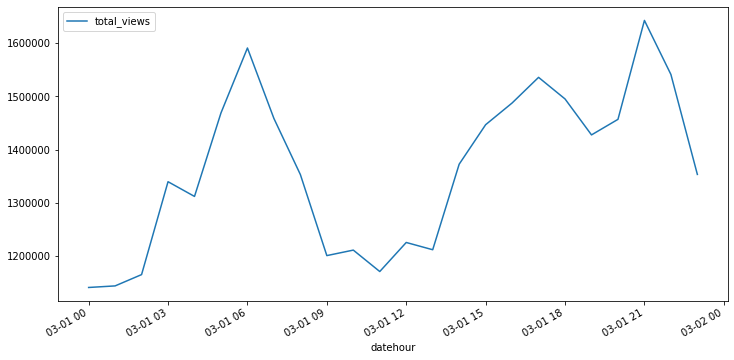

In [16]:
import matplotlib.pyplot as plt
pandas_datehour_totals.plot(kind='line',figsize=(12,6));

## Ploting Multiple Columns

In [17]:
# Creating a new Spark DataFrame and pivoting the wiki column to create multiple rows for each wiki value

import pyspark.sql.functions as F

df_wiki_totals = df_wiki_en \
.groupBy("datehour") \
.pivot("wiki") \
.agg(F.sum('views').alias('total_views'))

df_wiki_totals

datehour,en,en.m
2020-03-01 22:00:00,558358,983097
2020-03-01 09:00:00,638692,562285
2020-03-01 12:00:00,633432,592215
2020-03-01 20:00:00,615714,841337
2020-03-01 10:00:00,644680,566630
2020-03-01 05:00:00,588808,880260
2020-03-01 14:00:00,685500,687260
2020-03-01 19:00:00,592967,834844
2020-03-01 03:00:00,391300,948553
2020-03-01 01:00:00,360511,783510


## Converting to Pandas Dataframe

In [18]:
pandas_wiki_totals = df_wiki_totals.toPandas()

pandas_wiki_totals.set_index('datehour', inplace=True)
pandas_wiki_totals.head()

,en,en.m
datehour,,
2020-03-01 22:00:00,558358,983097
2020-03-01 09:00:00,638692,562285
2020-03-01 12:00:00,633432,592215
2020-03-01 20:00:00,615714,841337
2020-03-01 10:00:00,644680,566630


## Ploting with line for each column

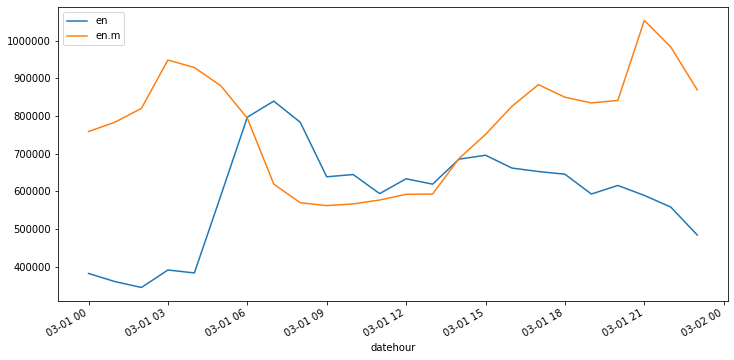

In [19]:
pandas_wiki_totals.plot(kind='line',figsize=(12,6))